In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  
 0   550.61346   15.421524  18.445875  
 1   905.11600   14.925031  31.019386  
 2   596.05396   14.681485  22.270780  
 3   414.38370   19.306356  16.183300  
 4   273.81440   16.112896  26.251837  ,
 (43775350, 8))

In [3]:
random_rows = df_transcripts.sample(n=10000, random_state=1)  # random_state is used for reproducibility

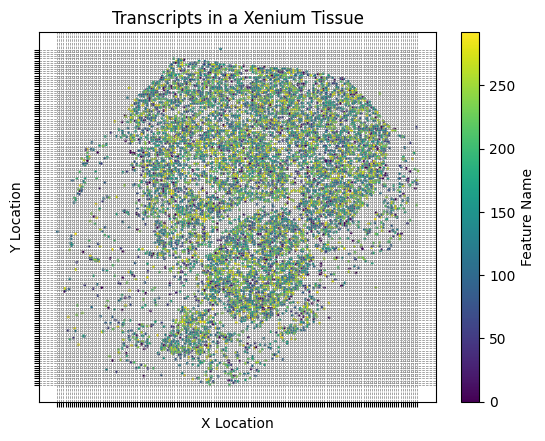

In [4]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1, c=pd.Categorical(random_rows["feature_name"]).codes, cmap='viridis')
plt.colorbar(label='Feature Name')  # Adds a colorbar with labels to the plot
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Transcripts in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

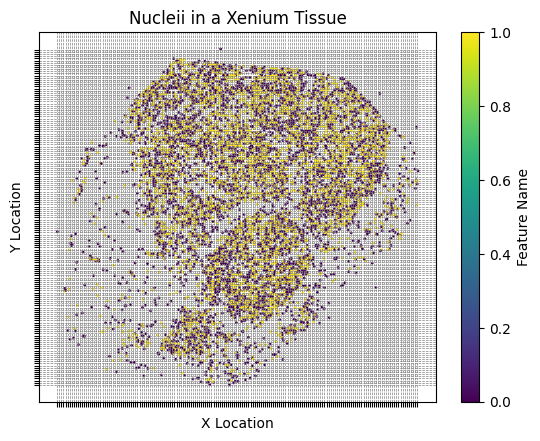

In [5]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1, c=random_rows["overlaps_nucleus"], cmap='viridis')
plt.colorbar(label='Feature Name')  # Adds a colorbar with labels to the plot
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Nucleii in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

# EDA on Spot Data

For now, we will focus on the 2D case and ignore the 3D information.

In [56]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [57]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [58]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [62]:
clustering.xenium_spot_data.obs

,spot_number,x_location,y_location,z_location,row,col
0,18,58.685923,1860.775855,11.995915,18.0,0.0
1,19,48.868837,1948.936671,11.944450,19.0,0.0
2,20,44.957070,2062.145073,11.886400,20.0,0.0
3,21,64.296418,2135.863892,11.883457,21.0,0.0
4,22,40.359721,2275.333869,12.084637,22.0,0.0
...,...,...,...,...,...,...
7307,9145,10209.827800,6787.376660,24.731413,67.0,102.0
7308,9146,10247.916375,6830.041012,24.520689,68.0,102.0
7309,9147,10248.615000,6923.818400,24.694735,69.0,102.0
7310,9231,10303.937000,6412.000000,24.712805,64.0,103.0


### PCA on Unfiltered Spot Data

In [55]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=50)
clustering.xenium_spot_data.obsm["X_pca"]

(7312, 50)

In [50]:
clustering.xenium_spot_data.varm["PCs"]
clustering.xenium_spot_data.varm["PCs"]

array([[-0.08201569, -0.10246794,  0.00155436, ...,  0.0280475 ,
        -0.03695033, -0.00433225],
       [-0.07539996,  0.08549378, -0.0564924 , ...,  0.02994743,
         0.00168998, -0.01484693],
       [-0.06632275,  0.02272117, -0.02546248, ...,  0.02022079,
         0.0151507 , -0.03519609],
       ...,
       [-0.04725812,  0.08744886, -0.04181348, ...,  0.0892242 ,
         0.03976699,  0.08490759],
       [-0.04931512,  0.12792942, -0.0506216 , ..., -0.01878605,
        -0.05826849,  0.01520033],
       [-0.08442935, -0.0152686 , -0.00559765, ...,  0.00490379,
         0.01495373,  0.02659018]])

In [51]:
data = np.save('PC.npy', clustering.xenium_spot_data.varm["PCs"])

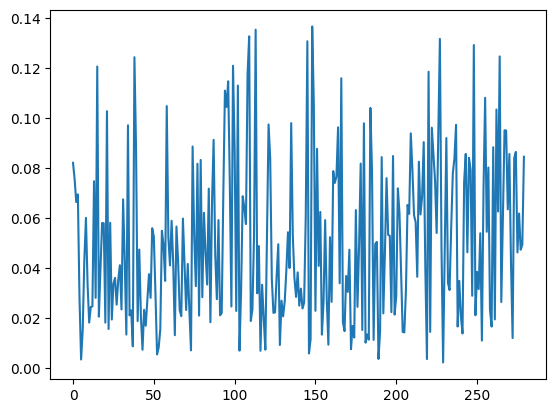

In [52]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

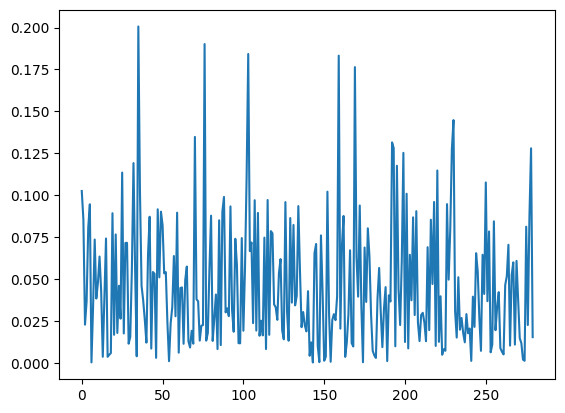

In [53]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

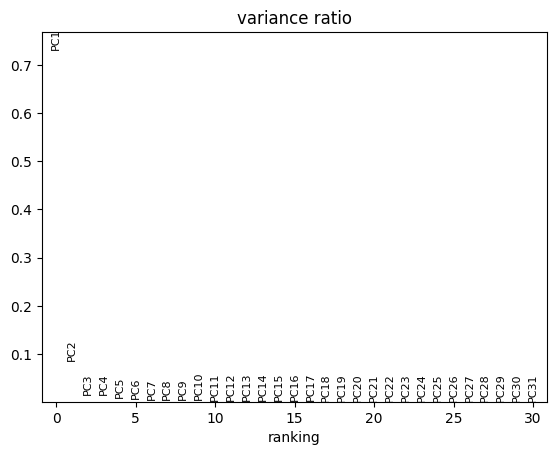

<Figure size 640x480 with 0 Axes>

In [54]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
plt.savefig("results/EDA/spotPCA.png")

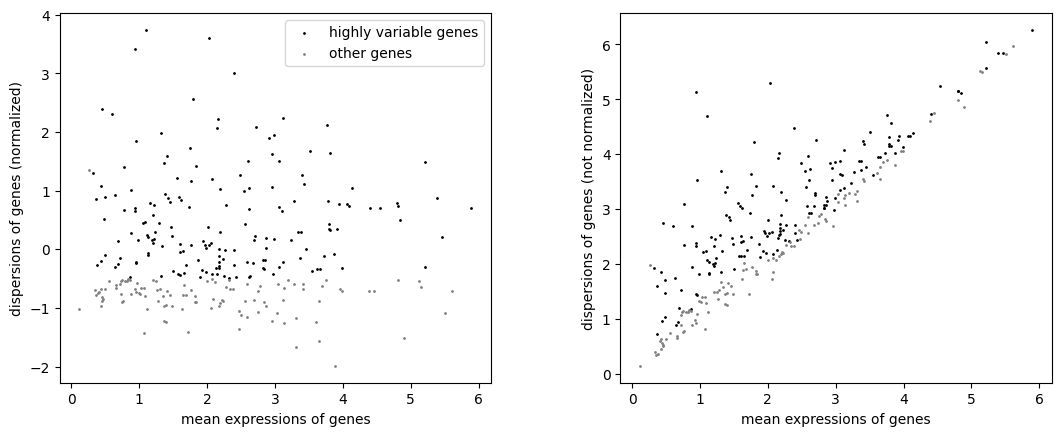

In [14]:
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, plot_highly_variable_genes=True)

### PCA on Highly-Variable Spot Data

In [15]:
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
clustering.xenium_spot_data.obsm["X_pca"]

array([[ 2.1155056e+01, -5.4236507e+00,  2.0466990e+00, ...,
         3.9729184e-01, -8.3824076e-02, -2.0354150e-01],
       [ 2.1070641e+01, -5.6439409e+00,  2.1660337e+00, ...,
        -1.1177375e-01,  3.9777905e-03,  5.1005155e-02],
       [ 2.0890097e+01, -5.5450473e+00,  2.1540532e+00, ...,
         2.9742104e-01,  1.2235555e-01,  7.8696674e-03],
       ...,
       [ 2.1647491e+01, -5.6506290e+00,  2.1944153e+00, ...,
         3.3974978e-01,  5.0348636e-02, -2.5710562e-01],
       [ 2.1715868e+01, -5.7138386e+00,  2.2376385e+00, ...,
         3.2959709e-01,  4.0335078e-02, -2.2141641e-01],
       [ 2.1642092e+01, -5.7624626e+00,  2.2334089e+00, ...,
         3.3015153e-01,  5.9149377e-02, -2.2588079e-01]], dtype=float32)

In [16]:
clustering.xenium_spot_data.varm["PCs"]

array([[-0.10699564, -0.11410391,  0.00117439, ..., -0.03022742,
        -0.01986326,  0.01722844],
       [-0.0986475 ,  0.09119226, -0.06235806, ...,  0.01464726,
         0.01444651, -0.05148864],
       [-0.08648925,  0.02269415, -0.02386993, ..., -0.0395036 ,
         0.00219862, -0.05452655],
       ...,
       [-0.10936521, -0.0045643 , -0.06428538, ...,  0.01780843,
        -0.02518753,  0.03106353],
       [-0.06078764,  0.08463245, -0.05683716, ..., -0.11386029,
         0.00363337, -0.07797775],
       [-0.06466508,  0.1365315 , -0.05529846, ...,  0.03566939,
        -0.00137214, -0.00676752]])

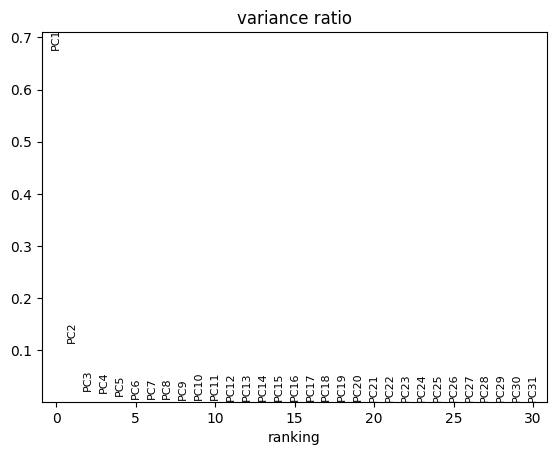

In [17]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)

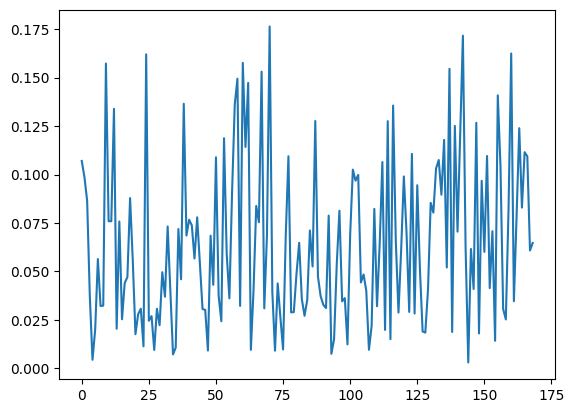

In [18]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

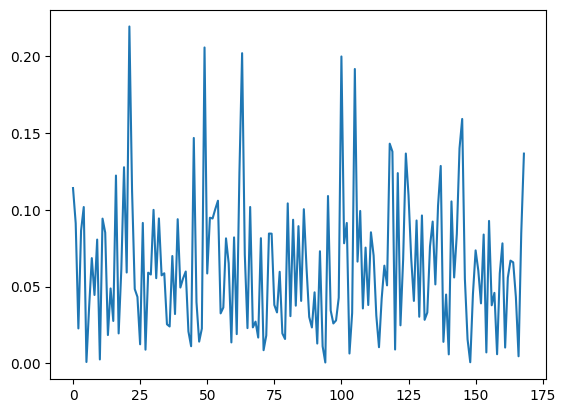

In [19]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

In [20]:
clustering.xenium_spot_data.var

,highly_variable,means,dispersions,dispersions_norm
ABCC11,True,2.953047,3.744833,1.633337
ACTA2,True,3.785395,4.306623,0.821881
ACTG2,True,2.702556,3.293917,0.228456
ADGRE5,True,1.497032,1.916026,-0.362325
ADH1B,True,2.189261,3.317184,1.025289
...,...,...,...,...
TRIB1,True,2.911854,3.839642,1.891252
TUBA4A,True,3.123837,3.380066,-0.212255
USP53,True,3.544375,3.630508,-0.375634
VWF,True,2.611254,3.533479,0.686099


# EDA on Cell Data

In [21]:
cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
cells_pivot = cells.pivot_table(index='cell_id', 
                                columns='feature_name', 
                                values='count', 
                                fill_value=0)
cells_pivot.shape

(356743, 541)

In [22]:
location_means = df_transcripts.groupby('cell_id').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

cells_pivot = location_means.join(cells_pivot, on='cell_id')

In [23]:
# log normalization
cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

In [24]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
0,-1,3891.438437,3353.932461,18.408364,5.361292,8.715716,7.280008,7.457609,5.978886,9.069698,...,6.714171,5.347108,3.433987,7.768956,7.106606,7.209340,6.652863,7.809135,8.440960,6.621406
1,1,1587.163466,1683.353685,15.503466,0.000000,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.000000,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.412715,1514.380829,14.616766,0.000000,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.000000,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.000000,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147


In [25]:
random_cells = cells_pivot.sample(n=10000, random_state=1)  # random_state is used for reproducibility

In [26]:
int(random_cells["x_location"].min()), int(random_cells["x_location"].max())


(542, 10018)

In [27]:
int(random_cells["y_location"].min()), int(random_cells["y_location"].max())

(115, 8480)

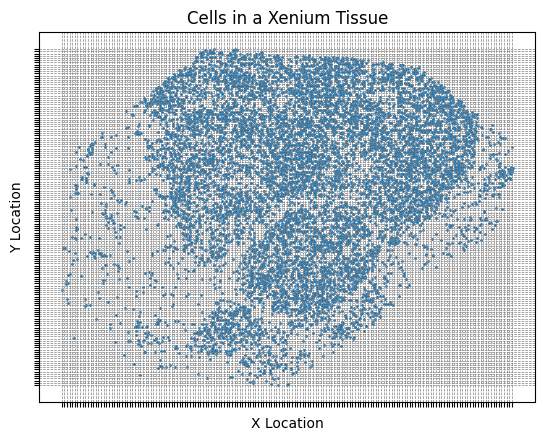

In [28]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

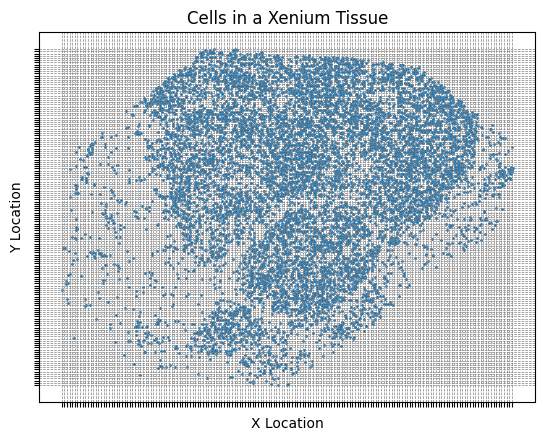

In [29]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

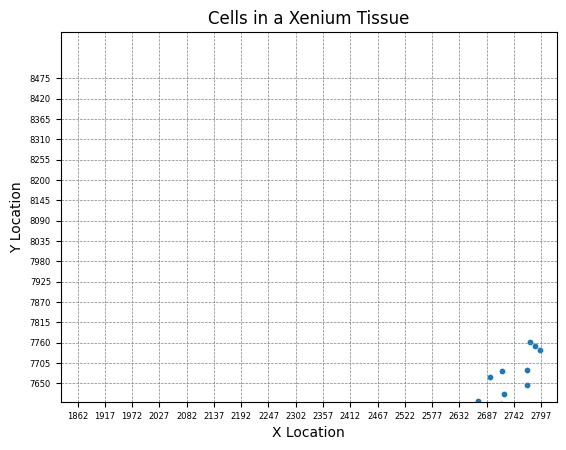

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'random_cells' is your DataFrame and it contains 'x_location' and 'y_location'

# Create scatter plot
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=10)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')

# Define the grid interval
k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), fontsize=6)
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), fontsize=6)

# Set gridlines
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

# Define the zoom area size
zoom_size = 1000  # Define how large the zoom area should be

# Select a random center point for the zoom
center_x = np.random.randint(2100, 2500)
center_y = np.random.randint(7000, random_cells["y_location"].max())

# Set the limits for the zoom area
plt.xlim(center_x - zoom_size / 2, center_x + zoom_size / 2)
plt.ylim(center_y - zoom_size / 2, center_y + zoom_size / 2)

plt.savefig("results/EDA/zoomed_cells.png")

# Show the plot with zoomed area
plt.show()


In [31]:
pca = PCA(n_components=20)
pca.fit(cells_pivot.iloc[:, 4:])

PCA(n_components=20)

In [32]:
np.set_printoptions(suppress=True)
print(np.round(pca.explained_variance_ratio_, 4))

[0.2425 0.0601 0.0271 0.0231 0.0196 0.0173 0.0119 0.0114 0.0108 0.0096
 0.0093 0.0085 0.0079 0.0076 0.0074 0.007  0.0069 0.0067 0.0065 0.0064]


In [33]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
0,-1,3891.438437,3353.932461,18.408364,5.361292,8.715716,7.280008,7.457609,5.978886,9.069698,...,6.714171,5.347108,3.433987,7.768956,7.106606,7.209340,6.652863,7.809135,8.440960,6.621406
1,1,1587.163466,1683.353685,15.503466,0.000000,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.000000,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.412715,1514.380829,14.616766,0.000000,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.000000,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.000000,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147


In [34]:
genes = cells_pivot.iloc[:, 4:]
gene_variances = genes.var(axis=0)
gene_variances.sort_values(ascending=False)

GATA3         0.915181
SCD           0.873970
SERPINA3      0.866281
KRT7          0.816820
TACSTD2       0.789063
                ...   
BLANK_0393    0.000146
BLANK_0383    0.000144
BLANK_0449    0.000128
BLANK_0180    0.000112
BLANK_0186    0.000097
Length: 541, dtype: float64